In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import syft as sy
from syft.core.node.vm.vm import VirtualMachine
from syft.core.node.vm.client import VirtualMachineClient
from syft.ast.module import Module
from syft.core.remote_dataloader import RemoteDataLoader
from syft.core.remote_dataloader import RemoteDataset

print(f'torch version: {torch.__version__}')
print(f'syft version: {sy.__version__}')


torch version: 1.8.1+cu102
syft version: 0.5.0


## Files and Directories

In [2]:
# paths to files and directories
project_path = Path.cwd().parent
print(f'project_path: {project_path}')
data_dir = 'mitdb'
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'
all_name = 'all_ecg.hdf5'
model_dir = 'model'
model_name = 'conv2'
model_ext = '.pth'
csv_dir = 'csv'
csv_ext = '.csv'
csv_name = 'conv2'
csv_accs_name = 'accs_conv2'

project_path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/teslak80-56gbram/code/Users/dkn.work/split-learning-he


## Construct the client and server

In [3]:
server: VirtualMachine = sy.VirtualMachine(name="server")
client: VirtualMachineClient = server.get_root_client()

In [4]:
remote_torch: Module = client.torch
remote_torch

Module:
	.Tensor -> <syft.ast.klass.Class object at 0x7fd300880280>
	.BFloat16Tensor -> <syft.ast.klass.Class object at 0x7fd3008802e0>
	.BoolTensor -> <syft.ast.klass.Class object at 0x7fd300880340>
	.ByteTensor -> <syft.ast.klass.Class object at 0x7fd3008803a0>
	.CharTensor -> <syft.ast.klass.Class object at 0x7fd300880400>
	.DoubleTensor -> <syft.ast.klass.Class object at 0x7fd300880460>
	.FloatTensor -> <syft.ast.klass.Class object at 0x7fd3008804c0>
	.HalfTensor -> <syft.ast.klass.Class object at 0x7fd300880520>
	.IntTensor -> <syft.ast.klass.Class object at 0x7fd300880580>
	.LongTensor -> <syft.ast.klass.Class object at 0x7fd3008805e0>
	.ShortTensor -> <syft.ast.klass.Class object at 0x7fd300880640>
	.nn -> Module:
		.Parameter -> <syft.ast.klass.Class object at 0x7fd300880760>
		.Module -> <syft.ast.klass.Class object at 0x7fd3007cdac0>
		.Conv2d -> <syft.ast.klass.Class object at 0x7fd3007cdfa0>
		.Dropout2d -> <syft.ast.klass.Class object at 0x7fd3007d4400>
		.Linear -> <syft.

## Client: loading and exploring the dataset

In [5]:
client_cuda = False
client_cuda_ptr = remote_torch.cuda.is_available()
client_cuda = bool(client_cuda_ptr.get(
    request_block=True,
    reason="To run test and inference locally",
    timeout_secs=5,  # change to something slower
))
print(f'client has cuda? {client_cuda}')

client_device_ptr = remote_torch.device("cuda" if client_cuda else "cpu")
print(f"client device is {client_device_ptr.get_copy()}")

client has cuda? True
client device is cuda


In [6]:
class ECG(Dataset):
    # The class used to load the ECG dataset
    def __init__(self, mode='train', client_device_ptr=None):
        if mode == 'train':
            with h5py.File(project_path/data_dir/train_name, 'r') as hdf:
                self.x = torch.tensor(hdf['x_train'][:], dtype=torch.float)
                self.y = torch.tensor(hdf['y_train'][:])                
        elif mode == 'test':
            with h5py.File(project_path/data_dir/test_name, 'r') as hdf:
                self.x = torch.tensor(hdf['x_test'][:], dtype=torch.float)
                self.y = torch.tensor(hdf['y_test'][:])
        else:
            raise ValueError('Argument of mode should be train or test')

        if client_device_ptr is not None:
            self.x = self.x.to(client_device_ptr.get_copy())
            # self.y = self.y.to(client_device_ptr.get_copy())

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
train_dataset = ECG(mode='train', client_device_ptr=client_device_ptr)
test_dataset = ECG(mode='test', client_device_ptr=client_device_ptr)

Let's first get everything in the dataset and see how many examples we have, and how each
of them look like

In [8]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))
ic(type(x_train), x_train.shape, x_train.device)
ic(type(y_train), y_train.shape, y_train.device)
ic(type(x_test), x_test.shape, x_test.device)
ic(type(y_test), y_test.shape, y_test.device)

ic| type(x_train): <class 'torch.Tensor'>
    x_train.shape: torch.Size([13245, 1, 128])
    x_train.device: device(type='cuda', index=0)
ic| type(y_train): <class 'torch.Tensor'>
    y_train.shape: torch.Size([13245])
    y_train.device: device(type='cpu')
ic| type(x_test): <class 'torch.Tensor'>
    x_test.shape: torch.Size([13245, 1, 128])
    x_test.device: device(type='cuda', index=0)
ic| type(y_test): <class 'torch.Tensor'>
    y_test.shape: torch.Size([13245])
    y_test.device: device(type='cpu')


(torch.Tensor, torch.Size([13245]), device(type='cpu'))

x_0: torch.Size([1, 128])
unrolling: torch.Size([128])


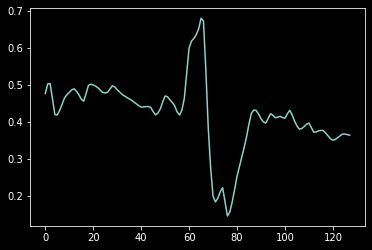

In [9]:
x0 = x_train[0, :, :]
print(f'x_0: {x0.shape}')
x0_unroll = x0.view(-1)
print(f'unrolling: {x0_unroll.shape}')
indx = np.arange(0, 128)

# plt.figure(figsize=(3,3))
plt.style.use('dark_background')
plt.plot(indx, x0_unroll.cpu())
plt.show()

The client creates the Dataset object and save it in a `.pt` file. 
If using `duet`, he can send the string path to the server using 
`sy.lib.python.String(string_path).send(duet, pointable=True, tags=["data"])`

In [10]:
torch.save(train_dataset, "train_dataset_cuda.pt")
torch.save(test_dataset, "test_dataset_cuda.pt")

## Server: creating remote dataset and dataloader

In [11]:
train_rds = RemoteDataset(path='train_dataset_cuda.pt', data_type="torch_tensor")
train_rds
train_rdl = RemoteDataLoader(remote_dataset=train_rds, batch_size=32)
train_rdl_ptr = train_rdl.send(client)
ic(train_rdl, train_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
train_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
train_rdl_ptr.create_dataloader()

ic| train_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7fd3005701f0>
    train_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7fd2fd8d0a30>


Testing the remote training data loader

In [12]:
for i, b in enumerate(train_rdl_ptr):
    if i<2:
        X, y = b[0], b[1]
        ic(X, y)
        try:
            ic(X.get_copy(), y.get_copy())
        except TypeError as e:
            ic(e)

ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd3003faa60>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd3005117c0>
ic| e: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")
ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd2fd9c3940>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd3003fa430>
ic| e: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")


Similarly, for the test dataset

In [13]:
test_rds = RemoteDataset(path='test_dataset_cuda.pt', data_type="torch_tensor")
test_rdl = RemoteDataLoader(remote_dataset=test_rds, batch_size=32)
test_rdl_ptr = test_rdl.send(client)
ic(test_rds, test_rdl, test_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
test_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
test_rdl_ptr.create_dataloader()

ic| test_rds: <class 'syft.core.remote_dataloader.remote_dataloader.RemoteDataset'>: torch_tensor
    test_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7fd300511d60>
    test_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7fd2fdad3ca0>


In [14]:
for i, b in enumerate(test_rdl_ptr):
    if i<2:
        X, y = b[0], b[1]
        ic(X, y)
        try:
            ic(X.get_copy(), y.get_copy())
        except TypeError as e:
            ic(e)

ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd3023c08e0>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd2fd8d0b20>
ic| e: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")
ic| X: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd300570a90>
    y: <syft.proxy.syft.lib.python.AnyPointer object at 0x7fd3003fa250>
ic| e: TypeError("can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.")


## Server: define the spit neural network used to train on the ECG dataset

Client's side contains conv layers

In [15]:
class EcgClient(sy.Module):
    # used by the data owners
    def __init__(self, torch_ref):
        super(EcgClient, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = self.torch_ref.nn.LeakyReLU()
        self.pool1 = self.torch_ref.nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = self.torch_ref.nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = self.torch_ref.nn.LeakyReLU()
        self.pool2 = self.torch_ref.nn.MaxPool1d(2)  # 32 x 16
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16)
        return x

Server's side contains fully connected layers

In [16]:
class EcgServer(sy.Module):
    def __init__(self, torch_ref):
        super(EcgServer, self).__init__(torch_ref=torch_ref)
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU() 
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.softmax4(x)
        return x

## Server: training process

In [17]:
ecg_client = EcgClient(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_client.conv1.weight.data = checkpoint["conv1.weight"]
ecg_client.conv1.bias.data = checkpoint["conv1.bias"]
ecg_client.conv2.weight.data = checkpoint["conv2.weight"]
ecg_client.conv2.bias.data = checkpoint["conv2.bias"]

ecg_server = EcgServer(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]

# Send the client's model to the client
ecg_client_ptr = ecg_client.send(client)

Putting the models on cuda

In [18]:
# if the client have CUDA lets send his model to the GPU
if client_cuda:
    print('putting the client model on cuda')
    ecg_client_ptr.cuda(client_device_ptr)
else:
    ecg_client_ptr.cpu()

putting the client model on cuda


In [19]:
# server side
server_cuda = torch.cuda.is_available()
print(f'server device has CUDA? {server_cuda}')
server_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"server's device: {torch.cuda.get_device_name(0)}")
if server_cuda:
    print('putting the server model on cuda')
    ecg_server.cuda(server_device)
else:
    ecg_server.cpu()

server device has CUDA? True
server's device: Tesla K80
putting the server model on cuda


Some hyper-parameters

In [20]:
total_batch = 414  # 32*414=13248. We have 13245 data samples

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001

optim_client = remote_torch.optim.Adam(params=ecg_client_ptr.parameters(), lr=lr)
optim_server = torch.optim.Adam(params=ecg_server.parameters(), lr=lr)

seed = 0  # the meaning of life
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
remote_torch.manual_seed(seed)

Training (with CUDA)

In [24]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy
for e in range(epoch):
    print(f"Epoch {e+1} - train ", end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i, batch in enumerate(tqdm(train_rdl_ptr)):
        # if i == 10: break
        x_ptr, y_gt_ptr = batch[0], batch[1]
        # initialize all gradients to zero
        optim_server.zero_grad()
        optim_client.zero_grad()
        # compute and get the activation signals from the client model
        activs_ptr = ecg_client_ptr(x_ptr)
        activs_ptr_cpu = activs_ptr.cpu()
        # the server still gets access to plain activation signals
        activs = activs_ptr_cpu.clone().get(request_block=True)
        # the server continues the forward pass on the activation maps
        y_hat = ecg_server(activs.to(server_device))
        # the server asks to access ground truths in plain text
        y_gt = y_gt_ptr.get_copy().to(server_device)
        # calculates cross-entropy loss
        loss = criterion(y_hat, y_gt)
        train_loss += loss.item()
        correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
        # backward propagation (calculating gradients of the loss w.r.t the weights)
        loss.backward()
        # send the gradients to the client
        client_grad_ptr = activs.grad.clone().send(client)
        # update the gradients of the client's model
        activs_ptr.backward(client_grad_ptr.cuda())
        # update the weights based on the gradients
        optim_client.step()
        optim_server.step()
        total += len(y_gt)

    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)

    print(f'loss: {train_losses[-1]: .4f}, accuracy: {train_accs[-1]*100: 2f}')

    # testing
    with torch.no_grad():  
        test_loss = 0.0
        correct, total = 0, 0
        for i, batch in enumerate(tqdm(test_rdl_ptr)):
            # if i == 10: break
            x_ptr, y_gt_ptr = batch[0], batch[1]
            # forward pass
            activs_ptr = ecg_client_ptr(x_ptr)
            activs_ptr_cpu = activs_ptr.cpu()
            activs = activs_ptr_cpu.clone().get(request_block=True)
            y_hat = ecg_server(activs.to(server_device))
            # the server asks to access ground truths in plain text
            y_gt = y_gt_ptr.get_copy().to(server_device)
            # calculate test loss
            loss = criterion(y_hat, y_gt)
            test_loss += loss.item()
            correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
            total += len(y_gt)

        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        print(f'test_loss: {test_losses[-1]: .4f}, test_acc: {test_accs[-1]*100: 2f}')
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]

Epoch 1 - train loss:  1.0772, accuracy:  83.873160
test_loss:  1.0587, test_acc:  85.330313
Epoch 2 - train loss:  1.0502, accuracy:  85.881465
test_loss:  1.0339, test_acc:  87.436769
Epoch 3 - train loss:  1.0407, accuracy:  86.674217
test_loss:  1.0279, test_acc:  88.055870
Epoch 4 - train loss:  1.0361, accuracy:  87.051718
test_loss:  1.0236, test_acc:  88.252171
Epoch 5 - train loss:  1.0308, accuracy:  87.602869
test_loss:  1.0354, test_acc:  87.240468
Epoch 6 - train loss:  1.0316, accuracy:  87.421669
test_loss:  1.0199, test_acc:  88.576821
Epoch 7 - train loss:  1.0273, accuracy:  87.791619
test_loss:  1.0215, test_acc:  88.440921
Epoch 8 - train loss:  1.0247, accuracy:  88.048320
test_loss:  1.0191, test_acc:  88.546621
Epoch 9 - train loss:  1.0221, accuracy:  88.229521
test_loss:  1.0142, test_acc:  89.022273
Epoch 10 - train loss:  1.0220, accuracy:  88.274821
test_loss:  1.0174, test_acc:  88.780672
Epoch 11 - train loss:  1.0201, accuracy:  88.365421
test_loss:  1.01

  2%|▏         | 7/414 [00:01<01:10,  5.76it/s]